In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 設定繪圖風格與字體
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['PingFang TC', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 1. 載入資料
df = pd.read_csv('data/tracks_features.csv')

print("原始資料載入完成")
print(f"原始資料形狀: {df.shape}")
display(df.head(5))

原始資料載入完成
原始資料形狀: (1204025, 24)


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [14]:
# 以下根據EDA發現的資料狀況進行前處理，清理的步驟會以註解的方式呈現在程式碼之前

# 1. Load Data
df = pd.read_csv('data/tracks_features.csv')
print(f"載入原始資料: {df.shape}")

# 2. Deduplication
# Remove duplicate track_ids to prevent popularity bias
if 'track_id' in df.columns:
    df = df.drop_duplicates(subset=['track_id'])

# 3. Data Cleaning & Outlier Removal (EDA Planning)
# - Remove Tempo == 0 
# - Remove Duration < 30000ms 
# - Remove Year < 1900 
# - Remove Time_signature == 0 
mask = (
    (df['tempo'] > 0) & 
    (df['duration_ms'] > 30000) & 
    (df['year'] >= 1900) & 
    (df['time_signature'] > 0)
)
df = df[mask].copy()

# 4. Feature Transformation (Log Transform)
# Fix extreme right-skewness in 'speechiness' and 'liveness'
skew_cols = ['speechiness', 'liveness']
# 使用 log1p 避免 log(0) 無限大問題，並處理可能的 NaN
df[skew_cols] = df[skew_cols].apply(np.log1p)

# 5. Multicollinearity Handling
# Drop 'loudness' (>0.7 correlation with energy)
if 'loudness' in df.columns:
    df = df.drop(columns=['loudness'])
feature_cols_check = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'speechiness', 'tempo', 'valence'
]
df = df.dropna(subset=feature_cols_check)

# 6. Save Processed Data
df.to_csv('spotify_processed_full.csv', index=False)

# Final Output Verification
print("-" * 30)
print(f"Processing complete. File saved to 'spotify_processed_full.csv'")
print(f"Final Shape: {df.shape}")

載入原始資料: (1204025, 24)
------------------------------
Processing complete. File saved to 'spotify_processed_full.csv'
Final Shape: (1195666, 23)


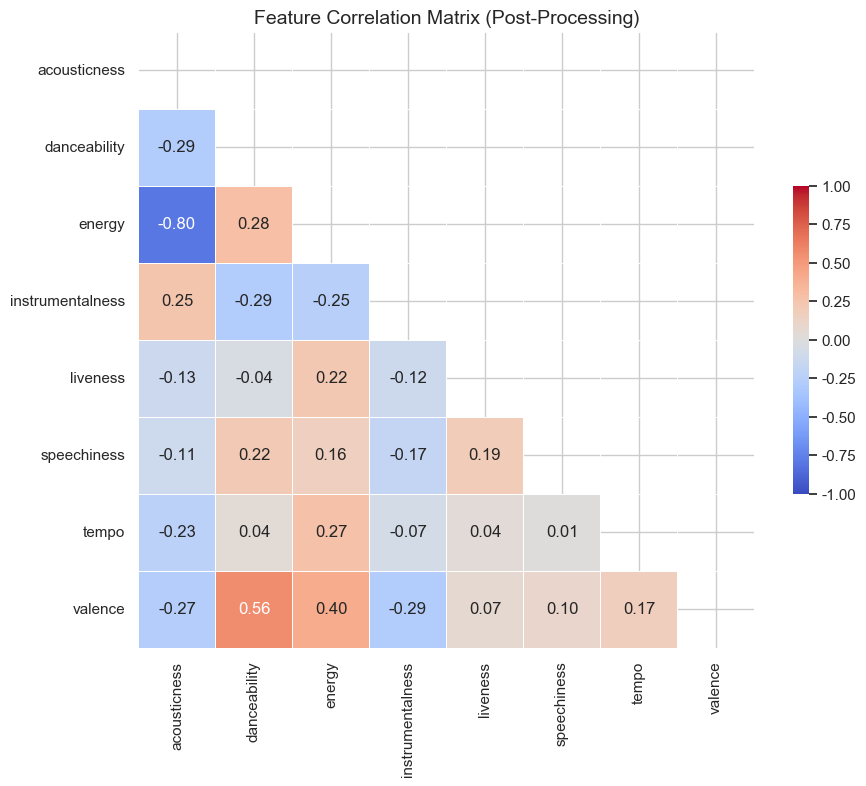

In [12]:
# 前處理後設檢查
df_viz = pd.read_csv('spotify_processed_full.csv')


feature_cols = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'speechiness', 'tempo', 'valence'
]

# 計算相關係數矩陣
corr = df_viz[feature_cols].corr()

# 繪製熱力圖
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool)) 

sns.heatmap(
    corr, 
    mask=mask, 
    cmap='coolwarm', 
    vmax=1, 
    vmin=-1, 
    center=0,
    annot=True, 
    fmt='.2f', 
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

plt.title('Feature Correlation Matrix (Post-Processing)', fontsize=14)
plt.show()

從上熱力圖可以看出，經過處理後沒有任何一個特徵跟彼此具有共線性問題。

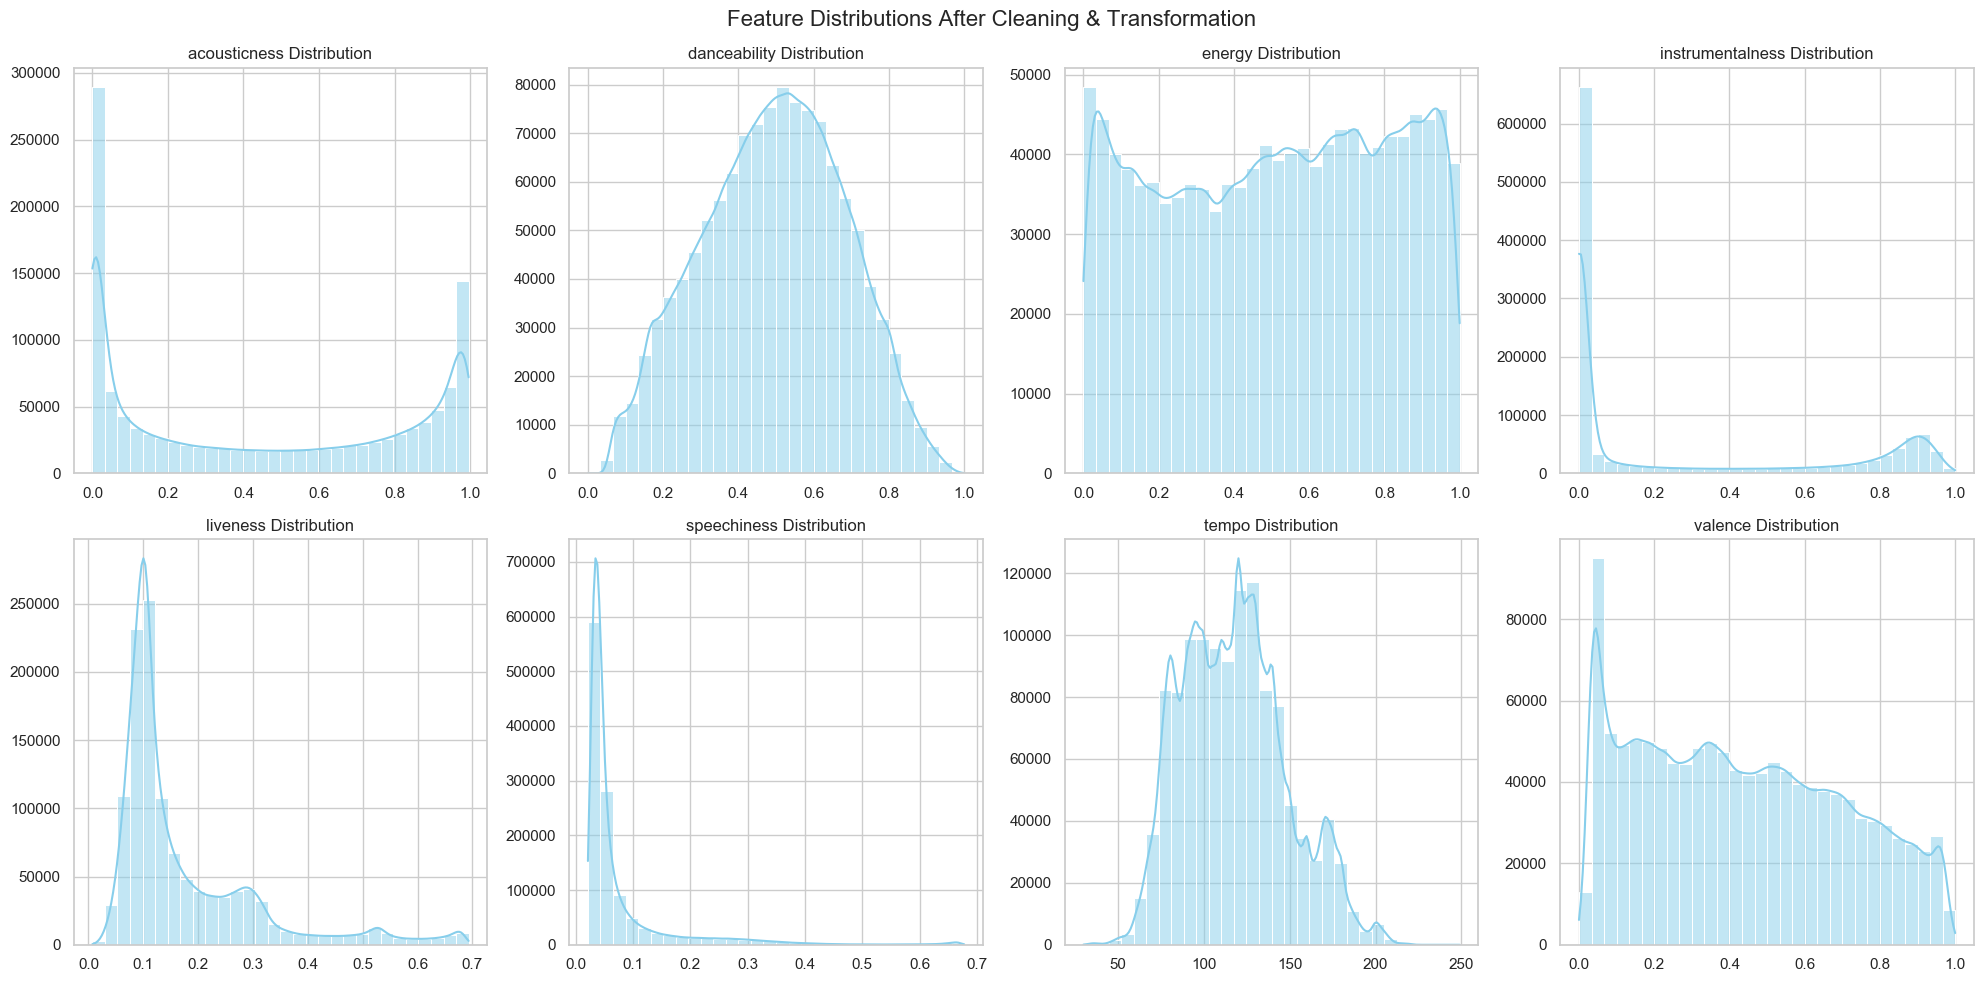

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.histplot(df_viz[col], kde=True, ax=axes[i], color='skyblue', bins=30)
    
    axes[i].set_title(f'{col} Distribution', fontsize=12)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')

plt.suptitle('Feature Distributions After Cleaning & Transformation', fontsize=16)
plt.tight_layout()
plt.show()

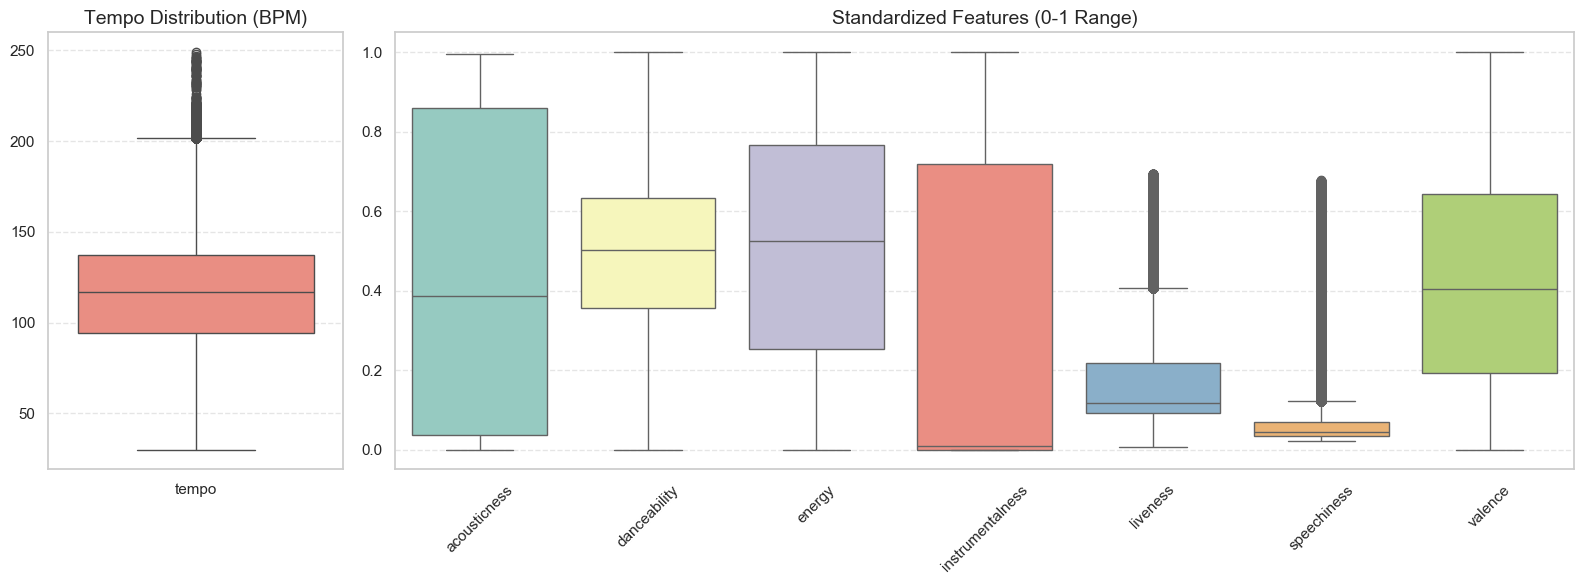

In [13]:
df_viz = pd.read_csv('spotify_processed_full.csv')

col_tempo = ['tempo']

cols_standard = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'speechiness', 'valence'
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 4]})

sns.boxplot(data=df_viz[col_tempo], ax=axes[0], color='salmon')
axes[0].set_title('Tempo Distribution (BPM)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

sns.boxplot(data=df_viz[cols_standard], ax=axes[1], palette='Set3')
axes[1].set_title('Standardized Features (0-1 Range)', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()